In [46]:
# Import Libraries
import requests
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [47]:
# The List of 20 type of cryptocurrency
coin_list = ['BTC', 'ETH', 'XRP', 'ADA', 'USDT', 'DOGE', 'XLM', 'DOT', 'UNI', 'LINK', 'USDC', 'BCH', 'LTC', 'GRT', 'ETC', 'FIL', 'AAVE', 'ALGO', 'EOS']

In [48]:
#defining the dataframe
main_df = pd.DataFrame()

In [49]:
for coin in coin_list:
    coin_df = pd.DataFrame()
    df = pd.DataFrame(index=[0])
    
    # Defining the Start Date and End Date
    datetime_end = datetime(2023, 3,14, 0, 0)
    datetime_check = datetime(2023, 2, 10, 0, 0)
    
    while len(df) > 0:
        if datetime_end == datetime_check:
            break
        
        datetime_start = datetime_end - relativedelta(hours = 12)
        
        #Api for the scrapping
        url = 'https://production.api.coindesk.com/v2/price/values/'+ coin +'?start_date='+datetime_start.strftime("%Y-%m-%dT%H:%M") + '&end_date=' + datetime_end.strftime("%Y-%m-%dT%H:%M") + '&ohlc=true'
        
        #we are using the request to fetch the data from the api in the json format and then storing it into the dataframe.
        temp_data = requests.get(url).json()
        df = pd.DataFrame(temp_data['data']['entries'])
        df.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close']
        
        # To handle the Missing Data
        insert_ids_list = [np.nan]
        
        '''In numerous occasions, I observed that CoinDesk did not collect every minute of data. 
        According to observation, in a normal circumstance, the timestamp would have a discrepancy
        value of 60000 for 1 minute. As a result, I can quickly tell that the missing period is the
        time gap if the row difference for the timestamp is larger than 60000. To deal with it, a
        hot-deck imputation procedure is used. To put it another way, the nearest minute data will 
        be substituted for the missing one.
        '''
        
        while len(insert_ids_list) > 0:
            timestamp_checking = np.array(df['Timestamp'][1:]) - np.array(df['Timestamp'][:-1])
            insert_ids_list = np.where(timestamp_checking!= 60000)[0]
            if len(insert_ids_list) > 0:
                print(str(len(insert_ids_list)) + ' mismatched.')
                insert_ids = insert_ids_list[0]
                temp_df = df.iloc[insert_ids.repeat(int(timestamp_checking[insert_ids]/60000)-1)].reset_index(drop=True)
                temp_df['Timestamp'] = [temp_df['Timestamp'][0] + i*60000 for i in range(1, len(temp_df)+1)]
                df = df.loc[:insert_ids].append(temp_df).append(df.loc[insert_ids+1:]).reset_index(drop=True)
                insert_ids_list = insert_ids_list[1:]
                
        
        #adding datetime and symbol to dataframe
        df = df.drop(['Timestamp'], axis=1)
        df['Datetime'] = [datetime_end - relativedelta(minutes=len(df)-i) for i in range(0, len(df))]
        coin_df = df.append(coin_df)
        datetime_end = datetime_start
        
    coin_df['Symbol'] = coin
    main_df = main_df.append(coin_df)


In [50]:
main_df = main_df[['Datetime', 'Symbol', 'Open', 'High', 'Low', 'Close']].reset_index(drop=True)
main_df

,Datetime,Symbol,Open,High,Low,Close
0,2023-02-10 00:00:00,BTC,21799.275559,21806.935743,21786.364483,21805.075909
1,2023-02-10 00:01:00,BTC,21803.436291,21804.906166,21786.488570,21788.505064
2,2023-02-10 00:02:00,BTC,21790.187371,21790.187371,21764.554702,21771.965702
3,2023-02-10 00:03:00,BTC,21776.865732,21812.047902,21776.865732,21810.874444
4,2023-02-10 00:04:00,BTC,21813.383272,21824.856418,21809.537916,21824.856418
...,...,...,...,...,...,...
875515,2023-03-13 23:55:00,EOS,1.074822,1.075691,1.074782,1.074855
875516,2023-03-13 23:56:00,EOS,1.074827,1.076692,1.074827,1.076670
875517,2023-03-13 23:57:00,EOS,1.076669,1.076772,1.075882,1.075993
875518,2023-03-13 23:58:00,EOS,1.075940,1.078734,1.075917,1.078734


In [51]:
main_df.to_csv('cryptocurrencies_df.csv', index=False)

In [52]:
%pip install plotly
%pip install pyspark
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install pandas_datareader
%pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
#importing libraries
import os
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import plotly.express as px
import matplotlib.pyplot as plt


#for bold
start='\033[1m'
end='\033[0;0m'

In [87]:
df=pd.read_csv('cryptocurrencies_df.csv')

In [88]:
df['Datetime']=pd.to_datetime(df['Datetime']).dt.date

In [89]:
df.tail(10)

,Datetime,Symbol,Open,High,Low,Close
875510,2023-03-13,EOS,1.075879,1.076846,1.075879,1.076002
875511,2023-03-13,EOS,1.075933,1.076000,1.074008,1.074881
875512,2023-03-13,EOS,1.074887,1.074887,1.073894,1.073961
875513,2023-03-13,EOS,1.074020,1.075046,1.073937,1.074968
875514,2023-03-13,EOS,1.074949,1.074957,1.074785,1.074828
875515,2023-03-13,EOS,1.074822,1.075691,1.074782,1.074855
875516,2023-03-13,EOS,1.074827,1.076692,1.074827,1.076670
875517,2023-03-13,EOS,1.076669,1.076772,1.075882,1.075993
875518,2023-03-13,EOS,1.075940,1.078734,1.075917,1.078734
875519,2023-03-13,EOS,1.078732,1.078745,1.077805,1.077823


In [90]:
spark = SparkSession.builder.appName('CheckPyspark').master("local").getOrCreate()

In [91]:
sparkDF=spark.createDataFrame(df) 

In [92]:
sparkDF.createOrReplaceTempView("crypto")

In [93]:
dfBTC = spark.sql(" select * from crypto where Symbol='BTC' ")

In [94]:
dfBTC.show()

+----------+------+----------------+----------------+----------------+----------------+
|  Datetime|Symbol|            Open|            High|             Low|           Close|
+----------+------+----------------+----------------+----------------+----------------+
|2023-02-10|   BTC|21799.2755594122|21806.9357432482|21786.3644827014| 21805.075908849|
|2023-02-10|   BTC|21803.4362912869|21804.9061662986|21786.4885695108|21788.5050636914|
|2023-02-10|   BTC|21790.1873705095|21790.1873705095| 21764.554702067|21771.9657024475|
|2023-02-10|   BTC|21776.8657324028| 21812.047902105|21776.8657324028|21810.8744435648|
|2023-02-10|   BTC|21813.3832716763|21824.8564184217|21809.5379158301|21824.8564184217|
|2023-02-10|   BTC|21825.6835036075|21827.3180770283|21798.2358139253|21822.8249644144|
|2023-02-10|   BTC|21823.6085357949|21838.2429546287| 21819.740127751|21838.2429546287|
|2023-02-10|   BTC|21838.2754205205|21848.1014537792|21838.2754205205|21847.1890822334|
|2023-02-10|   BTC|21846.6516452

In [95]:
dfETH = spark.sql(" select * from crypto where Symbol='ETH' ")

In [96]:
dfETH .show()

+----------+------+---------------+---------------+---------------+---------------+
|  Datetime|Symbol|           Open|           High|            Low|          Close|
+----------+------+---------------+---------------+---------------+---------------+
|2023-02-10|   ETH|1545.5425691898|1545.7220988233|1544.3650312846|1545.2151267672|
|2023-02-10|   ETH|1545.2024542376|1545.4171229717|1544.0098714791|  1544.17082479|
|2023-02-10|   ETH|1544.1189249035|1544.1189249035|1542.6303370213|1543.3698574443|
|2023-02-10|   ETH|1543.5158287833|1546.7260188505|1543.5158287833|1546.7260188505|
|2023-02-10|   ETH|1546.9374601332|1548.3498277224|1546.9374601332|1548.3498277224|
|2023-02-10|   ETH|1548.3641149495|1548.4347984362|1546.0144587118|1547.5734946136|
|2023-02-10|   ETH|1547.6313227779|1549.6933167189|1547.4817583294|1549.6933167189|
|2023-02-10|   ETH|1549.6275702463|1551.4917597225|1549.6275702463|1550.6933929297|
|2023-02-10|   ETH|1551.0826368019|1551.4659546969|1550.3150194979|1550.3606

In [97]:
pandasBTCDF = dfBTC.toPandas()
pandasETHDF = dfETH.toPandas()

Finding the top 5 crytpocurrencies by market closing time

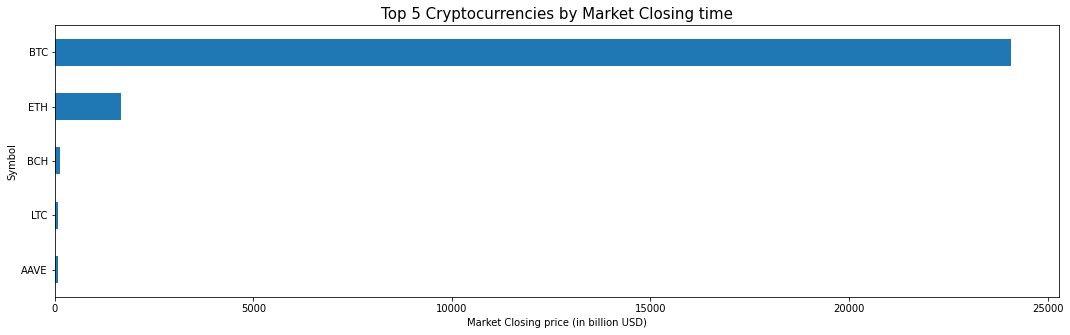

In [98]:
plt.figure(figsize=(18,5))
ax = df.groupby(['Symbol'])['Close'].last().sort_values(ascending=False).head(5).sort_values().plot(kind='barh')
ax.set_xlabel("Market Closing price (in billion USD)")
ax.ticklabel_format( style='plain', axis='x')
plt.title("Top 5 Cryptocurrencies by Market Closing time", fontsize=15)
plt.show()

Plotting Graphs of Closing Prices of Top 4 Cryptocurrencies as per Market Cap

In [99]:
dx=df.copy()

top_4_currency_names = dx.groupby(['Symbol'])['Close'].last().sort_values(ascending=False).head(4).index
top_4_currency_names_except_first=dx[dx['Symbol']!='BTC'].groupby(['Symbol'])['Close'].last().sort_values(ascending=False).head(4).index
top_4_currency_names_except_first_two=dx[(dx['Symbol']!='BTC') & (dx['Symbol']!='ETH')].groupby(['Symbol'])['Close'].last().sort_values(ascending=False).head(4).index
top_4_currency_names_except_first_two_three=dx[(dx['Symbol']!='BTC') & (dx['Symbol']!='ETH')& (dx['Symbol']!='USDT')].groupby(['Symbol'])['Close'].last().sort_values(ascending=False).head(4).index


data_top_4_currencies = dx[dx['Symbol'].isin(top_4_currency_names)]
top_4_currencies_after_BTC = dx[dx['Symbol'].isin(top_4_currency_names_except_first)]
top_4_currencies_after_BTC_ETH = dx[dx['Symbol'].isin(top_4_currency_names_except_first_two)]
top_4_currencies_after_BTC_ETH_USDT = dx[dx['Symbol'].isin(top_4_currency_names_except_first_two_three)]

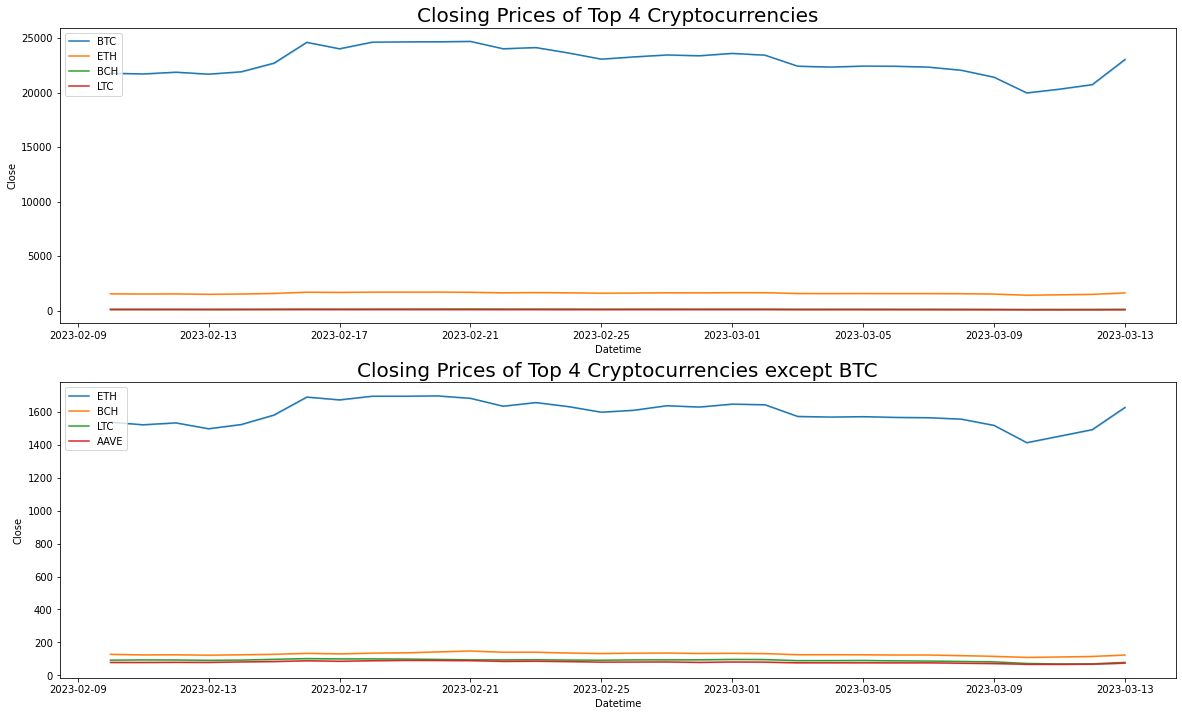

In [100]:
plt.figure(figsize=(20,25))

plt.subplot(4,1,1)
sns.lineplot(data=data_top_4_currencies, x="Datetime", y="Close", hue='Symbol')
plt.title("Closing Prices of Top 4 Cryptocurrencies", fontsize=20)
plt.legend(loc='upper left')

plt.subplot(4,1,2)
sns.lineplot(data=top_4_currencies_after_BTC, x="Datetime", y="Close", hue='Symbol')
plt.title("Closing Prices of Top 4 Cryptocurrencies except BTC", fontsize=20)
plt.legend(loc='upper left')




Pattern of data: bitcoin value always greater than

# Last 30 days average,max,min,std of Bitcoin

In [101]:
df_last30 = pandasBTCDF.groupby(['Datetime']).tail(30)
#last 30 days Btc average
df_average=df_last30.mean(axis = 0)
print("Last 30 days average price of Bitcoin\n",df_average)
print("\n\n")
df_btcmax=df_last30.max()
df_btcmin=df_last30.min()
print("Last 30 days MAX price of Bitcoin \n",df_btcmax)
print("\n\n")
print("Last 30 days MIN price of Bitcoin \n",df_btcmin)
print("\n\n")
stddf=df_last30.std(axis = 0, skipna = True)
print("standard deviation",stddf)

Last 30 days average price of Bitcoin
 Open     22886.963494
High     22895.369951
Low      22878.572186
Close    22887.155681
dtype: float64



Last 30 days MAX price of Bitcoin 
 Datetime      2023-03-13
Symbol               BTC
Open        24839.233058
High        24842.446908
Low         24830.711324
Close       24837.240283
dtype: object



Last 30 days MIN price of Bitcoin 
 Datetime      2023-02-10
Symbol               BTC
Open        20169.744845
High        20180.175039
Low         20163.053757
Close       20176.679985
dtype: object



standard deviation Open     1265.497531
High     1265.829333
Low      1264.996888
Close    1265.338199
dtype: float64


In [102]:
df1_last30 = pandasETHDF.groupby(['Datetime']).tail(30)
#last 30 days Btc average
df1_average=df1_last30.mean(axis = 0)
print("Last 30 days average price of Ethereum \n",df1_average)
print("\n\n")
df1_ethmax=df1_last30.max()
df1_ethmin=df1_last30.min()
print("Last 30 days MAX price of Ethereum \n",df1_ethmax)
print("\n\n")
print("Last 30 days MIN price of Ethereum \n",df1_ethmin)
print("\n\n")
stddf1=df1_last30.std(axis = 0, skipna = True)
print("standard deviation",stddf1)

Last 30 days average price of Ethereum 
 Open     1594.484607
High     1595.021204
Low      1593.974136
Close    1594.514492
dtype: float64



Last 30 days MAX price of Ethereum 
 Datetime     2023-03-13
Symbol              ETH
Open        1703.395184
High        1703.395184
Low         1702.940256
Close       1703.371568
dtype: object



Last 30 days MIN price of Ethereum 
 Datetime     2023-02-10
Symbol              ETH
Open        1428.133024
High        1429.804888
Low         1427.918213
Close       1428.124253
dtype: object



standard deviation Open     73.445794
High     73.436658
Low      73.468143
Close    73.450514
dtype: float64


In [103]:
print("Correlation between Ethereum OPEN VS BITCOIN OPEN",df1_last30['Open'].corr(df_last30['Open']))
print("Correlation between Ethereum CLOSE VS BITCOIN CLOSE",df1_last30['Close'].corr(df_last30['Close']))


Correlation between Ethereum OPEN VS BITCOIN OPEN 0.9824019505737079
Correlation between Ethereum CLOSE VS BITCOIN CLOSE 0.9823722282478581


Text(0, 0.5, 'ETH axis')

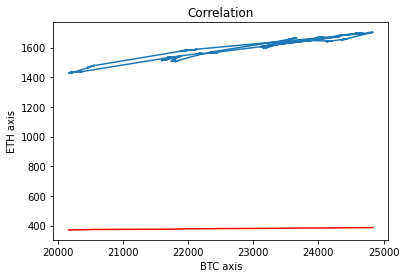

In [104]:
# adds the title
plt.title('Correlation')

# plot the data
plt.plot(df_last30['Open'],df1_last30['Open'])

# fits the best fitting line to the data
plt.plot(np.unique(df_last30['Open']),
		np.poly1d(np.polyfit(df_last30['Open'], df1_last30['Open'], 1))
		(np.unique(df1_last30['Open'])), color='red')

# Labelling axes
plt.xlabel('BTC axis')
plt.ylabel('ETH axis')




plotting the heatmap for correlation


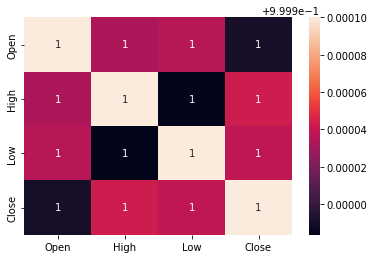

In [105]:
import seaborn as sns

# checking correlation using heatmap
#Loading dataset
#flights = sns.load_dataset("pandasETHDF")

print("plotting the heatmap for correlation")
ax = sns.heatmap(pandasETHDF.corr(), annot=True)



NO OUTLIERS

In [106]:
fig = px.box(df_last30,df_last30['Low'])

fig.show()

In [107]:
#How the prices of Bitcoin and Ethereum vary

Text(0.5, 1.0, 'Bitcoin market open price vs Date')

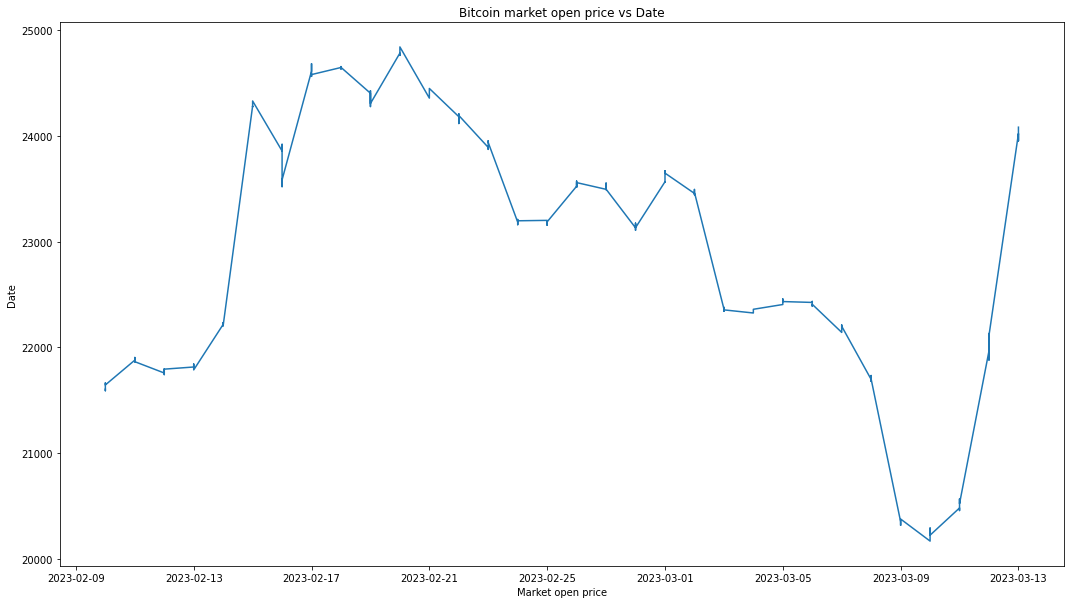

In [108]:
datebtc=df_last30['Datetime']
valuebtc=df_last30['Open']
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(datebtc, valuebtc);
plt.title("BTC DATETIME VS OPEN")
plt.ylabel("Date")
plt.xlabel("Market open price")
plt.title('Bitcoin market open price vs Date')


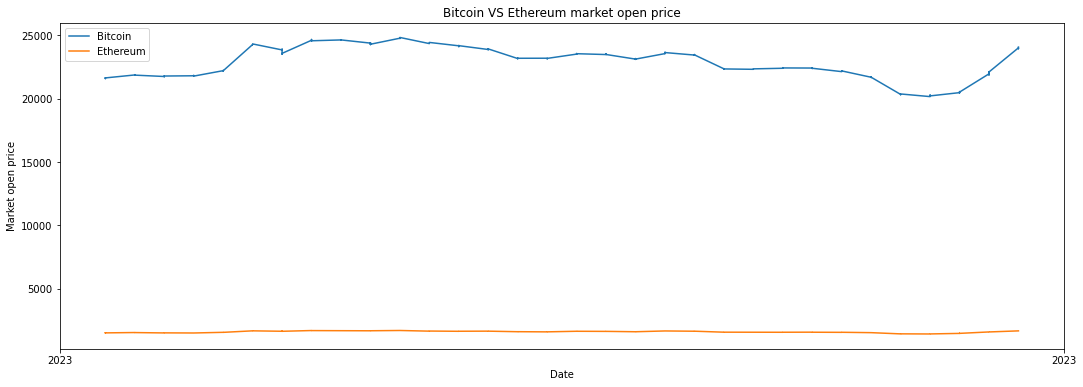

In [109]:
datebtc=df_last30['Datetime']
valuebtc=df_last30['Open']
datebtc1=df1_last30['Datetime']
valuebtc1=df1_last30['Open']
fig, ax = plt.subplots(figsize=(18, 6))

half_year_locator = mdates.MonthLocator(interval=200)
ax.xaxis.set_major_locator(half_year_locator) # Locator for major axis only.
line1, = ax.plot(datebtc, valuebtc, label='Bitcoin')
line2, = ax.plot(datebtc1,valuebtc1, label='Ethereum')
ax.legend(handles=[line1, line2])
#ax.plot(datebtc, valuebtc,datebtc1,valuebtc1,label='Bitcoin VS Ethereum market open price');
plt.xlabel("Date")
plt.ylabel("Market open price")
plt.title('Bitcoin VS Ethereum market open price')
ax.legend()


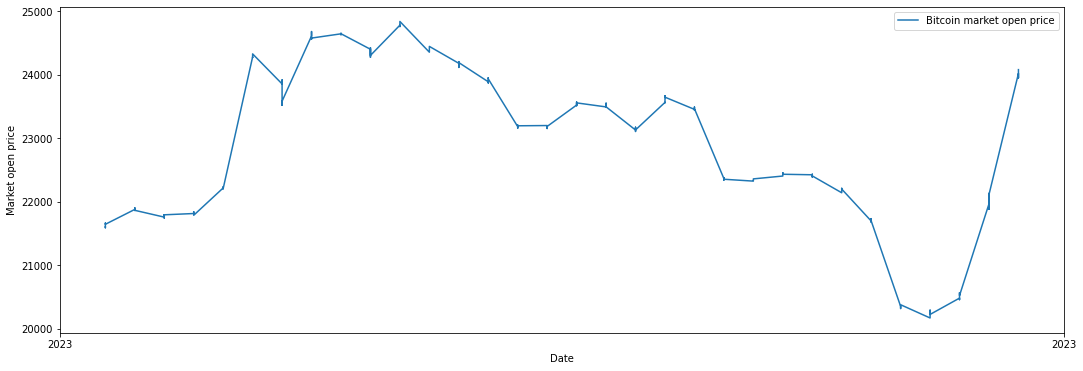

In [110]:
fig, ax = plt.subplots(figsize=(18, 6))

half_year_locator = mdates.MonthLocator(interval=200)
ax.xaxis.set_major_locator(half_year_locator) # Locator for major axis only.

ax.plot(datebtc, valuebtc,label='Bitcoin market open price')
plt.xlabel("Date")
plt.ylabel("Market open price")
plt.legend()


          Datetime Symbol          Open          High           Low  \
0       2023-02-10    BTC  21799.275559  21806.935743  21786.364483   
1       2023-02-10    BTC  21803.436291  21804.906166  21786.488570   
2       2023-02-10    BTC  21790.187371  21790.187371  21764.554702   
3       2023-02-10    BTC  21776.865732  21812.047902  21776.865732   
4       2023-02-10    BTC  21813.383272  21824.856418  21809.537916   
...            ...    ...           ...           ...           ...   
875515  2023-03-13    EOS      1.074822      1.075691      1.074782   
875516  2023-03-13    EOS      1.074827      1.076692      1.074827   
875517  2023-03-13    EOS      1.076669      1.076772      1.075882   
875518  2023-03-13    EOS      1.075940      1.078734      1.075917   
875519  2023-03-13    EOS      1.078732      1.078745      1.077805   

               Close  
0       21805.075909  
1       21788.505064  
2       21771.965702  
3       21810.874444  
4       21824.856418  
...      

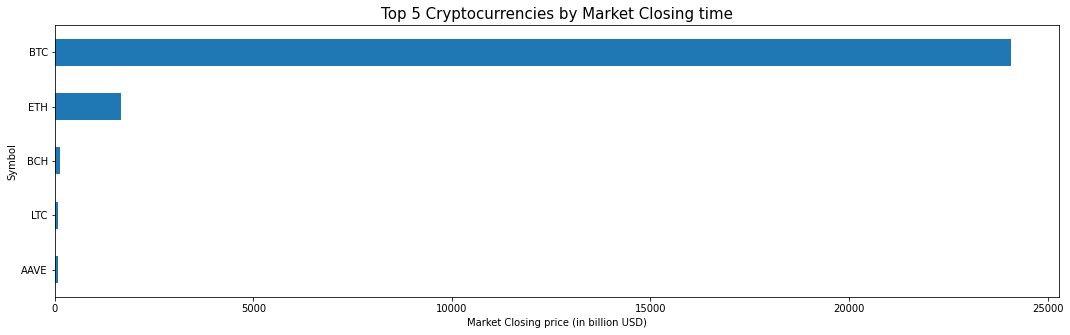

Plotting Graphs of Closing Prices of Top 4 Cryptocurrencies as per Market Cap
Pattern of data: bitcoin value always greater than etherium
Last 30 days average,max,min,std of Bitcoin
Last 30 days average price of Bitcoin
 Open     22886.963494
High     22895.369951
Low      22878.572186
Close    22887.155681
dtype: float64



Last 30 days MAX price of Bitcoin 
 Datetime      2023-03-13
Symbol               BTC
Open        24839.233058
High        24842.446908
Low         24830.711324
Close       24837.240283
dtype: object



Last 30 days MIN price of Bitcoin 
 Datetime      2023-02-10
Symbol               BTC
Open        20169.744845
High        20180.175039
Low         20163.053757
Close       20176.679985
dtype: object



standard deviation Open     1265.497531
High     1265.829333
Low      1264.996888
Close    1265.338199
dtype: float64
Last 30 days average price of Ethereum 
 Open     1594.484607
High     1595.021204
Low      1593.974136
Close    1594.514492
dtype: float64



Last 3

How do the prices of Bitcoin and Ethereum vary


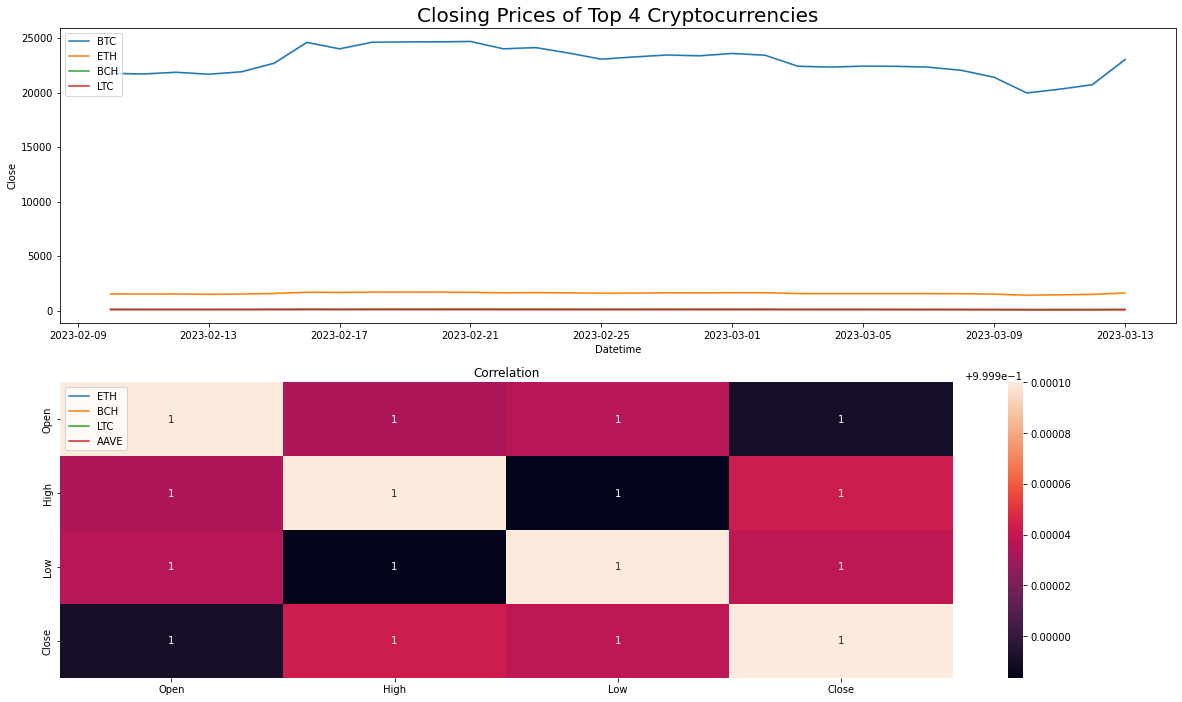

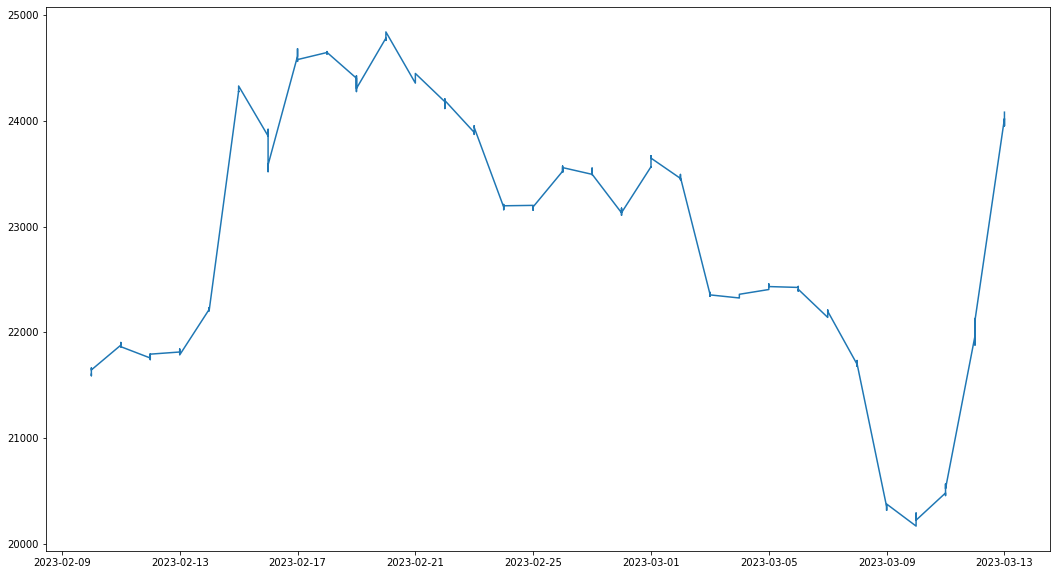

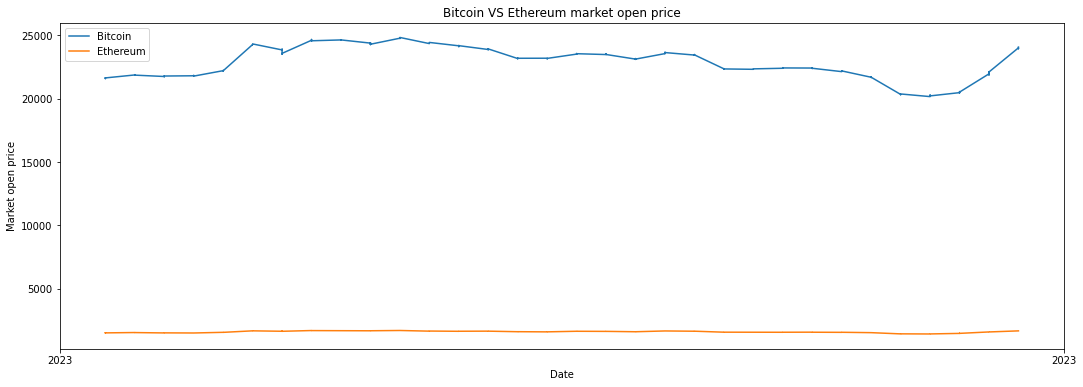

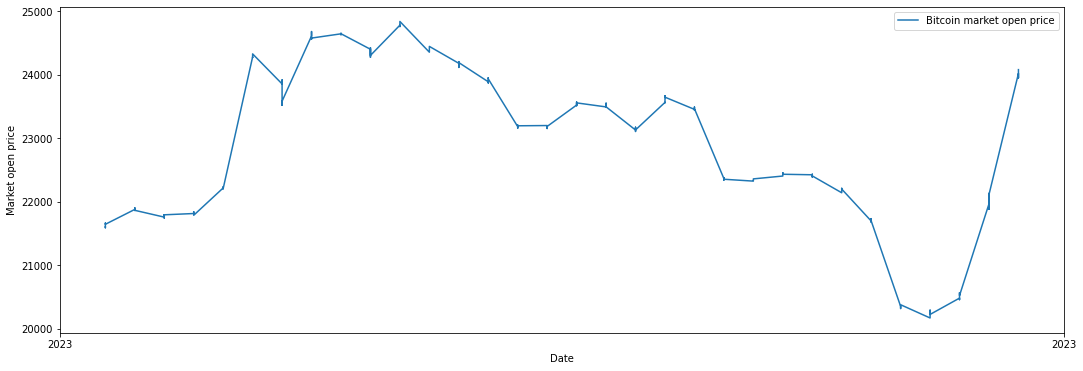

In [111]:
#importing libraries
import os
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import warnings
warnings.filterwarnings("ignore")
import matplotlib.dates as mdates


class Analysis:
    def  __init__(self):
        pass
    def analysis_helper(self):
        df=pd.read_csv('cryptocurrencies_df.csv')

        df['Datetime']=pd.to_datetime(df['Datetime']).dt.date

        print(df)

        spark = SparkSession.builder.appName('CheckPyspark').master("local").getOrCreate()

        sparkDF=spark.createDataFrame(df)

        sparkDF.createOrReplaceTempView("crypto")

        dfBTC = spark.sql(" select * from crypto where Symbol='BTC' ")

        #df.show()

        dfETH = spark.sql(" select * from crypto where Symbol='ETH' ")

        #dfETH .show()

        pandasBTCDF = dfBTC.toPandas()
        pandasETHDF = dfETH.toPandas()


        print("Finding the top 5 crytpocurrencies by market closing time")

        plt.figure(figsize=(18,5))
        ax = df.groupby(['Symbol'])['Close'].last().sort_values(ascending=False).head(5).sort_values().plot(kind='barh')
        ax.set_xlabel("Market Closing price (in billion USD)")
        ax.ticklabel_format( style='plain', axis='x')
        plt.title("Top 5 Cryptocurrencies by Market Closing time", fontsize=15)
        plt.show()

        print("Plotting Graphs of Closing Prices of Top 4 Cryptocurrencies as per Market Cap")

        dx=df.copy()

        top_4_currency_names = dx.groupby(['Symbol'])['Close'].last().sort_values(ascending=False).head(4).index
        top_4_currency_names_except_first=dx[dx['Symbol']!='BTC'].groupby(['Symbol'])['Close'].last().sort_values(ascending=False).head(4).index
        top_4_currency_names_except_first_two=dx[(dx['Symbol']!='BTC') & (dx['Symbol']!='ETH')].groupby(['Symbol'])['Close'].last().sort_values(ascending=False).head(4).index
        top_4_currency_names_except_first_two_three=dx[(dx['Symbol']!='BTC') & (dx['Symbol']!='ETH')& (dx['Symbol']!='USDT')].groupby(['Symbol'])['Close'].last().sort_values(ascending=False).head(4).index


        data_top_4_currencies = dx[dx['Symbol'].isin(top_4_currency_names)]
        top_4_currencies_after_BTC = dx[dx['Symbol'].isin(top_4_currency_names_except_first)]
        top_4_currencies_after_BTC_ETH = dx[dx['Symbol'].isin(top_4_currency_names_except_first_two)]
        top_4_currencies_after_BTC_ETH_USDT = dx[dx['Symbol'].isin(top_4_currency_names_except_first_two_three)]

        plt.figure(figsize=(20,25))

        plt.subplot(4,1,1)
        sns.lineplot(data=data_top_4_currencies, x="Datetime", y="Close", hue='Symbol')
        plt.title("Closing Prices of Top 4 Cryptocurrencies", fontsize=20)
        plt.legend(loc='upper left')

        plt.subplot(4,1,2)
        sns.lineplot(data=top_4_currencies_after_BTC, x="Datetime", y="Close", hue='Symbol')
        plt.title("Closing Prices of Top 4 Cryptocurrencies except BTC", fontsize=20)
        plt.legend(loc='upper left')

        print("Pattern of data: bitcoin value always greater than etherium")

        print("Last 30 days average,max,min,std of Bitcoin")
    

        df_last30 = pandasBTCDF.groupby(['Datetime']).tail(30)
        #last 30 days Btc average
        df_average=df_last30.mean(axis = 0)
        print("Last 30 days average price of Bitcoin\n",df_average)
        print("\n\n")
        df_btcmax=df_last30.max()
        df_btcmin=df_last30.min()
        print("Last 30 days MAX price of Bitcoin \n",df_btcmax)
        print("\n\n")
        print("Last 30 days MIN price of Bitcoin \n",df_btcmin)
        print("\n\n")
        stddf=df_last30.std(axis = 0, skipna = True)
        print("standard deviation",stddf)

        df1_last30 = pandasETHDF.groupby(['Datetime']).tail(30)
        #last 30 days Btc average
        df1_average=df1_last30.mean(axis = 0)
        print("Last 30 days average price of Ethereum \n",df1_average)
        print("\n\n")
        df1_ethmax=df1_last30.max()
        df1_ethmin=df1_last30.min()
        print("Last 30 days MAX price of Ethereum \n",df1_ethmax)
        print("\n\n")
        print("Last 30 days MIN price of Ethereum \n",df1_ethmin)
        print("\n\n")
        stddf1=df1_last30.std(axis = 0, skipna = True)
        print("standard deviation",stddf1)

        print("Correlation between Ethereum OPEN VS BITCOIN OPEN",df1_last30['Open'].corr(df_last30['Open']))
        print("Correlation between Ethereum CLOSE VS BITCOIN CLOSE",df1_last30['Close'].corr(df_last30['Close']))

        # adds the title
        plt.title('Correlation')

        # plot the data
        plt.scatter(df_last30['Open'],df1_last30['Open'])

        # fits the best fitting line to the data
        plt.plot(np.unique(df_last30['Open']),
                np.poly1d(np.polyfit(df_last30['Open'], df1_last30['Open'], 1))
                (np.unique(df1_last30['Open'])), color='red')

        # Labelling axes
        plt.xlabel('ETC axis')
        plt.ylabel('ETH axis')

    

        # checking correlation using heatmap
        #Loading dataset
 

        print("plotting the heatmap for correlation\n")
        ax = sns.heatmap(pandasETHDF.corr(), annot=True)

        print("NO OUTLIERS")

        fig = px.box(df_last30,df_last30['Low'])

        fig.show()

        print("How do the prices of Bitcoin and Ethereum vary")

        datebtc=df_last30['Datetime']
        valuebtc=df_last30['Open']
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(datebtc, valuebtc);

        datebtc=df_last30['Datetime']
        valuebtc=df_last30['Open']
        datebtc1=df1_last30['Datetime']
        valuebtc1=df1_last30['Open']
        fig, ax = plt.subplots(figsize=(18, 6))

        half_year_locator = mdates.MonthLocator(interval=200)
        ax.xaxis.set_major_locator(half_year_locator) # Locator for major axis only.
        line1, = ax.plot(datebtc, valuebtc, label='Bitcoin')
        line2, = ax.plot(datebtc1,valuebtc1, label='Ethereum')
        ax.legend(handles=[line1, line2])
        #ax.plot(datebtc, valuebtc,datebtc1,valuebtc1,label='Bitcoin VS Ethereum market open price');
        plt.xlabel("Date")
        plt.ylabel("Market open price")
        plt.title('Bitcoin VS Ethereum market open price')
        ax.legend()

        fig, ax = plt.subplots(figsize=(18, 6))

        half_year_locator = mdates.MonthLocator(interval=200)
        ax.xaxis.set_major_locator(half_year_locator) # Locator for major axis only.

        ax.plot(datebtc, valuebtc,label='Bitcoin market open price')
        plt.xlabel("Date")
        plt.ylabel("Market open price")
        plt.legend()


if __name__=="__main__":
    obj=Analysis()
    obj.analysis_helper()